In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.calibration import cross_val_predict
from sklearn.metrics import auc, roc_curve, make_scorer, fbeta_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


In [178]:
# Laster Data
data = "data/data.csv"
df = pd.read_csv(data)

data = load_breast_cancer(as_frame=True)

X = df.drop(['id', 'diagnosis'], axis=1)
y = df['diagnosis']

# Q 1.1

Load the dataset, inspect feature names and target distribution. Comment on
dataset imbalance. 

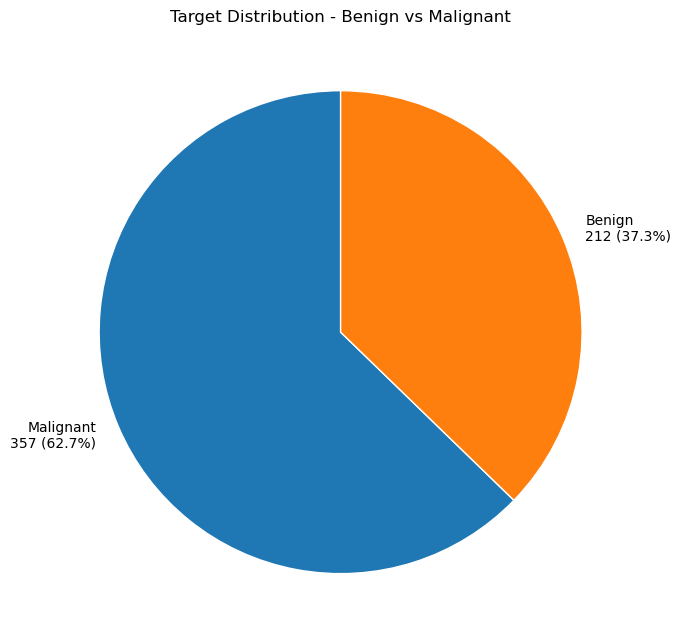

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [179]:
counts = y.value_counts().sort_index()
labels = ['Malignant', 'Benign']

percentages = 100 * counts / counts.sum()
custom_labels = [f"{lab}\n{cnt} ({pct:.1f}%)" for lab, cnt, pct in zip(labels, counts, percentages)]

plt.figure(figsize=(7, 7))
plt.pie(
    counts,
    labels=custom_labels,
    startangle=90,
    wedgeprops=dict(edgecolor="white")
)
plt.title("Target Distribution - Benign vs Malignant",)
plt.tight_layout()
plt.show()

X.describe()

# Q 1.2

Analyze all features with and without standardization (i.e., zero mean and unit
variance). Plot the feature analysis with and without standardization and decide
which version is more suitable.

In [180]:
scaler = StandardScaler() # (zero mean and unit variance)
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

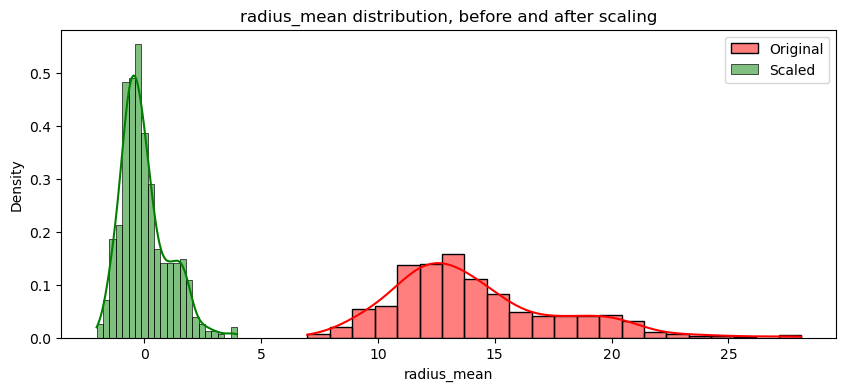

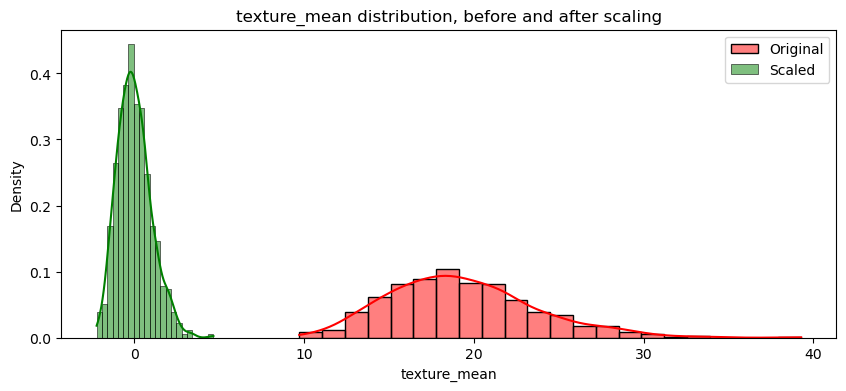

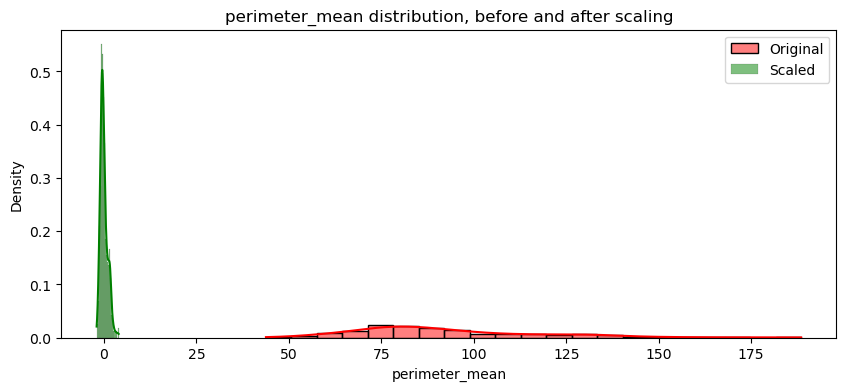

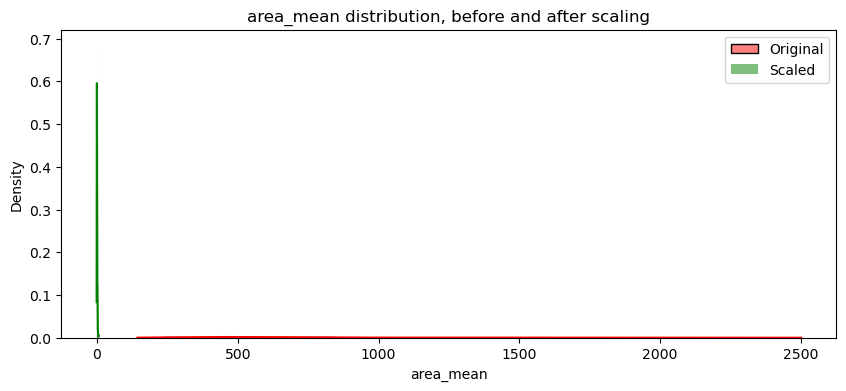

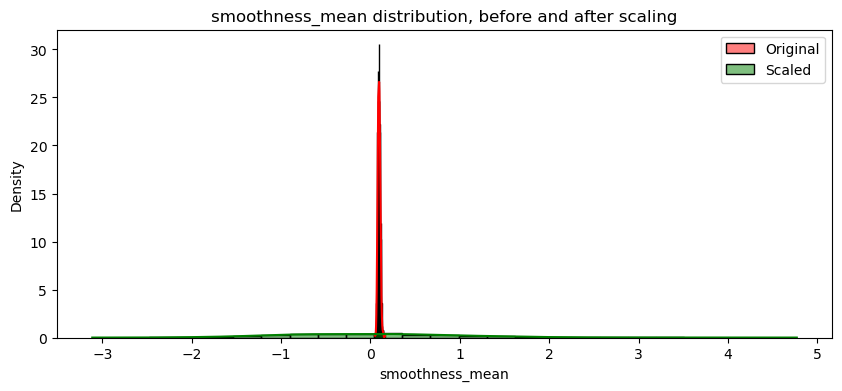

In [181]:
displayed_charts = 5

features_to_plot = X.columns[:displayed_charts]

for feature in features_to_plot:
    plt.figure(figsize=(10,4))
    
    # Original ( Blå )
    sns.histplot(X[feature], kde=True, color='red', stat='density', label='Original')
    
    # Scaled ( Grønn )
    sns.histplot(X_scaled_df[feature], kde=True, color='green', stat='density', alpha=0.5, label='Scaled')
    
    plt.title(f'{feature} distribution, before and after scaling')
    plt.legend()
    plt.show()

Vi ser at dataen blir bedre spredd rundt 0, og at tilfeller som `perimeter_mean` blir skalert bra, slik at det har en mindre inflytelse på variansen enn `smoothness_mean`. 

Til tre-baserte algoritmer har skalering ingenting å si, men gradient descent og avstand-baserte algoritmer får man mye mer menignsfull data. Gradient-descent konvergerer raskere, og nermeste-nabo får riktig klassifisering av naboer. SVM bruker L2 distance mellom punkter, så skalering betyr mye her også.

Den skalerte er mer passende for alle trenigns-algoritmer.

# Q 1.3

Comment on importance of three way split with respect to hyperparameter search
and robustness of any learned model. 

Et "three way split" refererer til å snippe datasettet opp i tre biter, et trenings-sett, et validerings-sett og et et test-set. Her bruker vi `60-20-20`

Ideen;
- Trenings-settet skal hjelpe til med å danne grunnlaget for modellen, altså grovarbeidet hvor den lærer monstre og justerer biaser/vekter
- Validerings-settet skal finjustere parameterne i modellen, her jobber vi på data vi aldri har sett før for å ikke skape overfitting (veldig spisset på vårt datasett, minde generelt)
- Test-settet brukes helt til slutt for å se hvor bra modellen vi har laget er blitt, og benyttes ikkke til å trene modellen.

### Hyperparameter søk
Når det kommer til hyperparameter, er dette ikke noe man kan komme frem til som med gradient descent, men noe man må velge. 

Om man kun bruker trening og test-sett, så vil man indirekte få modellen til å peke på testsettet som vil gi en falsk indikasjon på hvor bra modellen er, siden hvis modellen er finjustert til testsettet, så vil selvfølgelig test-settet gi gode resultater. Oppgaven er å generalisere gjett.

Ved å introdusere et validerinsssett så får man da et miljø hvor man kan velge hyperparameterene som passer "best" i fred og ro uten at det ødelegger resultatene via test-settet.

### Robusthet
Robusthet i en modell sier noe om hvor bra modellen generaliserer data som ikke er blitt sett før, altså ikke bare "memoriserer" trenings-settet.

Man kan se hvor godt modellen generaliserer godt basert på hvor lav erroren mellom Train og Validation er
- Lav error = God genralisering
- Høy forskjell i error = Dårlig (trenger mer data, annen pre-processing, andre hyperparametere under trening)


# Q 2.1

Train a Decision Tree classifier using default parameters. Evaluate it on validation
sets from original splits (report accuracy mean and std). 

In [182]:
# Bruker 60-20-20

# 1 - 80/100 ) 1 - 0.8 = 0.2
X_temp, X_test, y_temp, y_test = train_test_split(    
    X_scaled, y_encoded, test_size=0.2, random_state=1337, shuffle=True, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=1337, shuffle=True, stratify=y_temp
)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1337)

In [183]:
tree_clf = DecisionTreeClassifier(random_state=1337)

cv_scores = cross_val_score(tree_clf, X_train, y_train, cv=kf, scoring='accuracy') 
mean_acc = np.mean(cv_scores)
std_acc = np.std(cv_scores)
print(f"CV mean accuracy: {mean_acc:.4f}, std: {std_acc:.4f}")

# Trene med å bruke full trenigns-sett
tree_clf.fit(X_train, y_train)

# Evaluere med val
val_accuracy = tree_clf.score(X_val, y_val)

pred = tree_clf.predict(X_val)

print(f"Validation set accuracy: {val_accuracy:.4f}")

CV mean accuracy: 0.9325, std: 0.0303
Validation set accuracy: 0.9298


# Q 2.2

From the trained model, comment on feature importance values and identify the
top 3 features from your model.

In [184]:
tree_clf.fit(X_train, y_train)

feature_importances = pd.DataFrame({
    'Feature': X_scaled_df.columns,
    'Importance': tree_clf.feature_importances_
})

# Sortere (Få beste på topp)
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print("\nTop 3 important features:")
print(feature_importances.head(3))


Top 3 important features:
                 Feature  Importance
23            area_worst    0.745224
27  concave points_worst    0.121920
8          symmetry_mean    0.041682


Her er de tre viktiste featuresa fra modellen (Tatt fra decisiontreeclassifier fit og ikke 5fold cv)

Her er `area_worst` den med mest inflytelse på valgene i treet, omtrent 71% av alle branches kommer av denne.\
`concave poitns_worst` og `symmetry_mean` har også litt å si.



# Q 2.3

Vary the max depth parameter (e.g., depth 2-10). Use validation accuracy (mean
± std from cross-validation on the training set) to choose the best depth. Provide
performance for each chosen depth (at-least 5 to be reported) and discuss the aspects
of overfitting vs. underfitting. 

    max_depth  mean_cv_accuracy  std_cv_accuracy  val_accuracy
2           2          0.926641         0.027994      0.947368
3           3          0.920844         0.019841      0.929825
4           4          0.935422         0.025744      0.929825
5           5          0.935465         0.027314      0.929825
6           6          0.938406         0.030013      0.929825
7           7          0.932523         0.030333      0.929825
8           8          0.932523         0.030333      0.929825
9           9          0.932523         0.030333      0.929825
10         10          0.932523         0.030333      0.929825


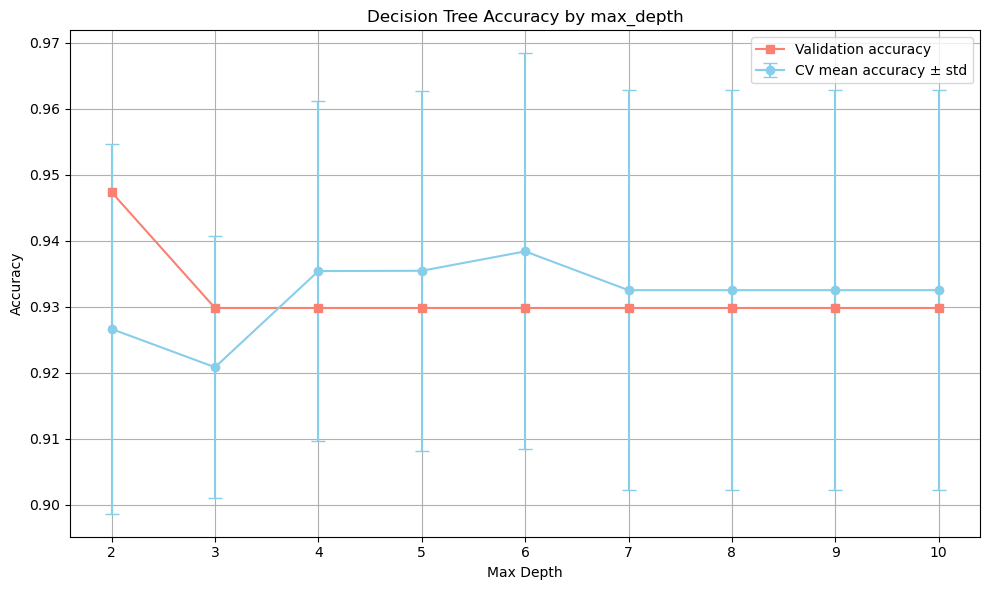

In [185]:
depths = list(range(2, 11)) # Fra 2 til 10
results_23 = []

for depth in depths:
    tree_clf = DecisionTreeClassifier(max_depth=depth, random_state=1337) # Dybde
    cv_scores = cross_val_score(tree_clf, X_train, y_train, cv=kf, scoring='accuracy')
    mean_cv = np.mean(cv_scores)
    std_cv = np.std(cv_scores)

    # Valideringssett
    tree_clf.fit(X_train, y_train)
    val_acc = tree_clf.score(X_val, y_val)
    
    results_23.append((depth, mean_cv, std_cv, val_acc))

df_23 = pd.DataFrame(results_23, columns=['max_depth', 'mean_cv_accuracy', 'std_cv_accuracy', 'val_accuracy'])
df_23.index += 2
print(df_23)

plt.figure(figsize=(10, 6))
plt.errorbar(df_23['max_depth'], df_23['mean_cv_accuracy'], yerr=df_23['std_cv_accuracy'],
             fmt='-o', capsize=5, color='skyblue', label='CV mean accuracy ± std')
plt.plot(df_23['max_depth'], df_23['val_accuracy'], '-s', color='salmon', label='Validation accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy by max_depth')
plt.xticks(df_23['max_depth'])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Beste dybden
Vi ser at de mest nøyaktige er `6`, men med svært høyt avvik. 
`3` er den med nest høyest nøyaktighet sammen med 4, men aller lavest avvik.

## Under- og overfitting
Underfitting er når en modell ikke fanger opp forhold mellom ulike features. Overfitting er når modellen tar med støy inn i likningen og blir hyperspesifikk mot trenignsdataen, selv støy.

Vi kan se på dataen som gis, at ved dypte `2`, så oppnår vi et lokalt maksima med accuracy. Vi får en ganske høy score, men det mangler noe som fanger sammengengen mellom de ulike featuressa her. Altså underfitting.

Vi ser på dypde `5` at vi havner på et stabilt nivå, hvor verken accuracy eller deviation øker eller minker. Modellen er stabil her. Vi ser ingen overfitting, da accuracy fortsatt ikke er nærme `1.0`. Men, det hadde holdt med 5 i dybde for å unngå kompleksitet.

Antakelig ser vi ingen overfitting på grunn av cross validation over 5 folds, som unnlater litt av dataen for hver treningsiterasjon.


# Q 2.4

Repeat previous exercise with different min samples leaf values. Which setting
generalizes best according to the validation set?

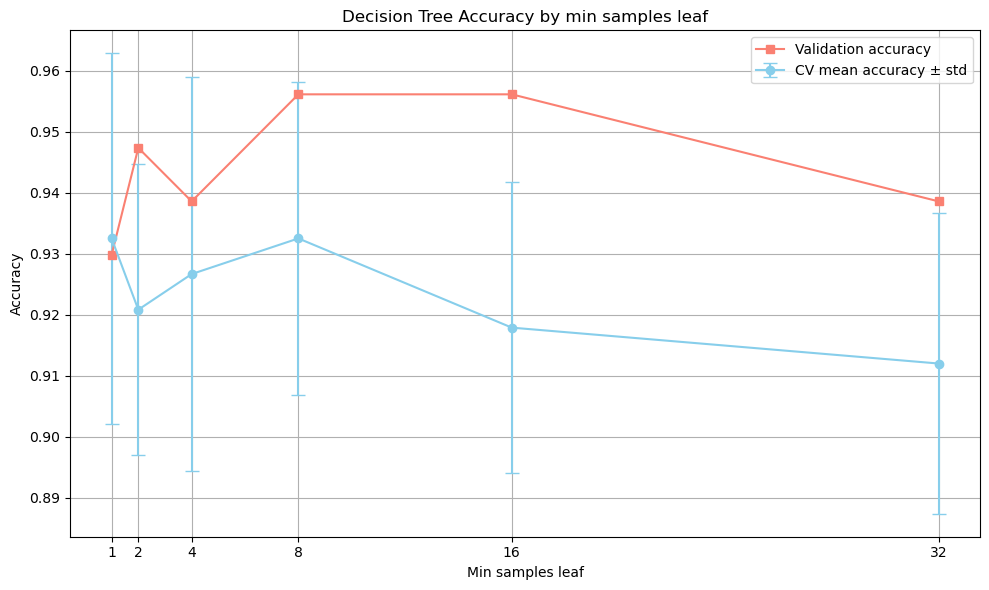

In [186]:
min_leaf_values = [1, 2, 4, 8, 16, 32]
results = []

for leaf_size in min_leaf_values:
    tree_clf = DecisionTreeClassifier(random_state=1337, min_samples_leaf=leaf_size)
    cv_scores = cross_val_score(tree_clf, X_train, y_train, cv=kf, scoring='accuracy')
    mean_acc = np.mean(cv_scores)
    std_acc = np.std(cv_scores)

    tree_clf.fit(X_train, y_train)
    val_acc = tree_clf.score(X_val, y_val)

    results.append((leaf_size, mean_acc, std_acc, val_acc))

df = pd.DataFrame(results, columns=['min_samples_leaf', 'mean_accuracy', 'std_accuracy', 'val_acc'])


plt.figure(figsize=(10, 6))
plt.errorbar(df['min_samples_leaf'], df['mean_accuracy'], yerr=df['std_accuracy'], fmt='-o', capsize=5, color='skyblue', label='CV mean accuracy ± std')
plt.plot(df['min_samples_leaf'], df['val_acc'], '-s', color='salmon', label='Validation accuracy')
plt.xlabel('Min samples leaf')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy by min samples leaf')
plt.xticks(df['min_samples_leaf'])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Nøyaktighet er best på `8`, samme med std avvik. 

På `1` og `3` er accuracy fortsatt høy, men siden bladene er så små så kan det fange veldig spesifikke mønstre (mild overfitting)

På `8+` så går accuracy ned, som tyder på at mer informasjon går tapt på grunn av treets manglende komplekshet = underfitting

# Q 3.1

Train a linear SVM (kernel="linear") and evaluate on validation sets (use the
original 5 splits that was created in previous exercise). Report accuracy mean, std
and plot the ROC for each split.

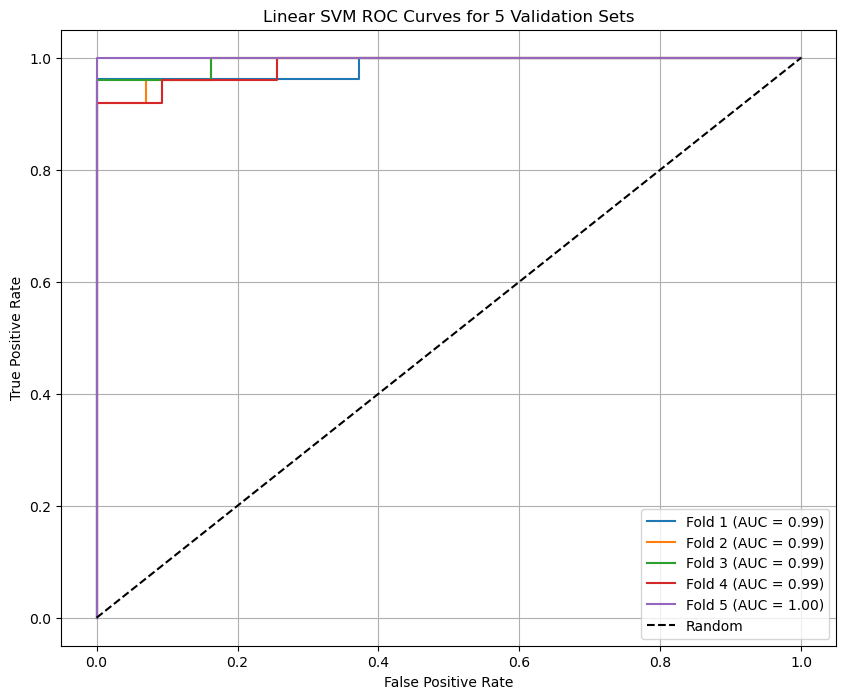

Linear SVM Accuracy across 5 validation sets:
Mean accuracy: 0.9677
Std accuracy:  0.0172


In [187]:
linear_svm = Pipeline([
    ("svm", SVC(kernel="linear", probability=True, random_state=1337))
])

accuracies = []
plt.figure(figsize=(10, 8))

for i, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), start=1):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    linear_svm.fit(X_tr, y_tr)
    
    y_pred = linear_svm.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)
    
    y_prob = linear_svm.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f"Fold {i} (AUC = {roc_auc:.2f})")



plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Linear SVM ROC Curves for 5 Validation Sets")
plt.legend()
plt.grid(True)
plt.show()

mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)

print(f"Linear SVM Accuracy across 5 validation sets:")
print(f"Mean accuracy: {mean_acc:.4f}")
print(f"Std accuracy:  {std_acc:.4f}")

# Q 3.2
Train an Radial Basis Function (RBF) kernel SVM. Compare its performance to
the linear kernel using validation accuracy. Plot ROC for these models.

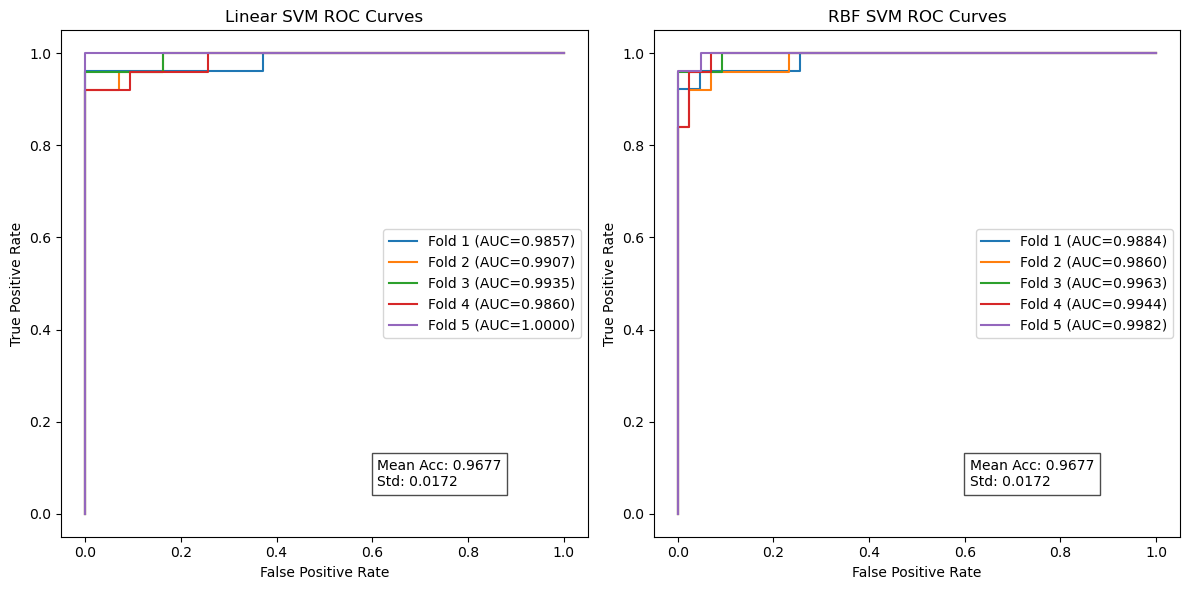

In [188]:
rbf_svm = Pipeline([
    ('svm', SVC(kernel='rbf', probability=True, random_state=1337))
])

plt.figure(figsize=(12, 6))

# Linear SVM
plt.subplot(1,2,1)
accuracies = []

for i, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), start=1):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    linear_svm.fit(X_tr, y_tr)

    y_pred = linear_svm.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)

    y_prob = linear_svm.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Fold {i} (AUC={roc_auc:.4f})")

mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)

# Add text to plot
plt.text(0.6, 0.1, f"Mean Acc: {mean_acc:.4f}\nStd: {std_acc:.4f}", transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.7))
plt.title("Linear SVM ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

# RBF SVM
plt.subplot(1,2,2)
accuracies = []

for i, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), start=1):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    rbf_svm.fit(X_tr, y_tr)

    y_pred = rbf_svm.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)

    y_prob = rbf_svm.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Fold {i} (AUC={roc_auc:.4f})")

mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)

plt.text(0.6, 0.1, f"Mean Acc: {mean_acc:.4f}\nStd: {std_acc:.4f}", transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.7))
plt.title("RBF SVM ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.tight_layout()
plt.show()

In [189]:
# Cross-validated accuracy
cv_scores = cross_val_score(rbf_svm, X_train, y_train, cv=kf, scoring='accuracy')
mean_acc = np.mean(cv_scores)
std_acc = np.std(cv_scores)

print(f"RBF SVM 5-fold CV Accuracy:")
print(f"Mean accuracy: {mean_acc:.4f}")
print(f"Std accuracy:  {std_acc:.4f}")

RBF SVM 5-fold CV Accuracy:
Mean accuracy: 0.9677
Std accuracy:  0.0172


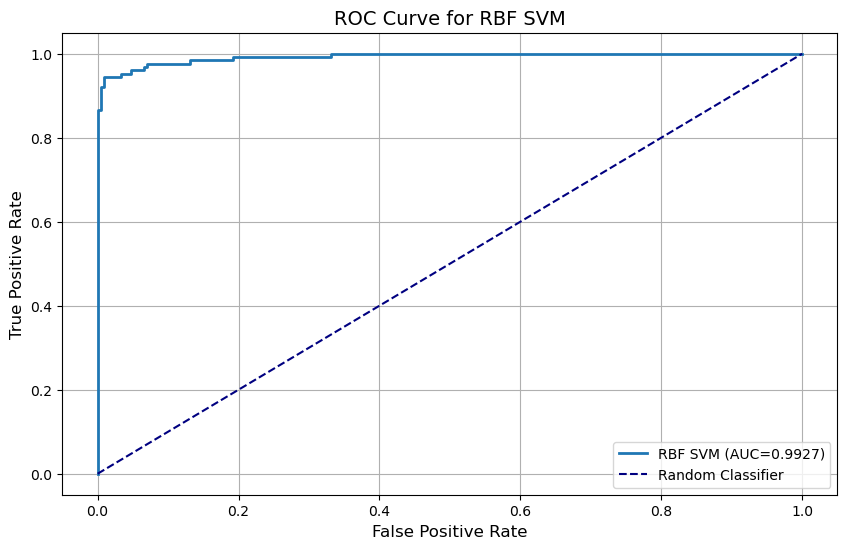

In [190]:
y_pred_prob = cross_val_predict(rbf_svm, X_train, y_train, cv=kf, method='predict_proba')

plt.figure(figsize=(10, 6))
fpr, tpr, _ = roc_curve(y_train, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'RBF SVM (AUC={roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Classifier')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve for RBF SVM", fontsize=14)
plt.legend(loc="lower right")
plt.grid()
plt.show()

Vi ser at begge SVM kernels får lit TPR på 0.7939


# Q 3.3
Experiment with different values of C (regularization strength). Use the validation
set to select the best C. Report results as a plot of accuracy vs. C.

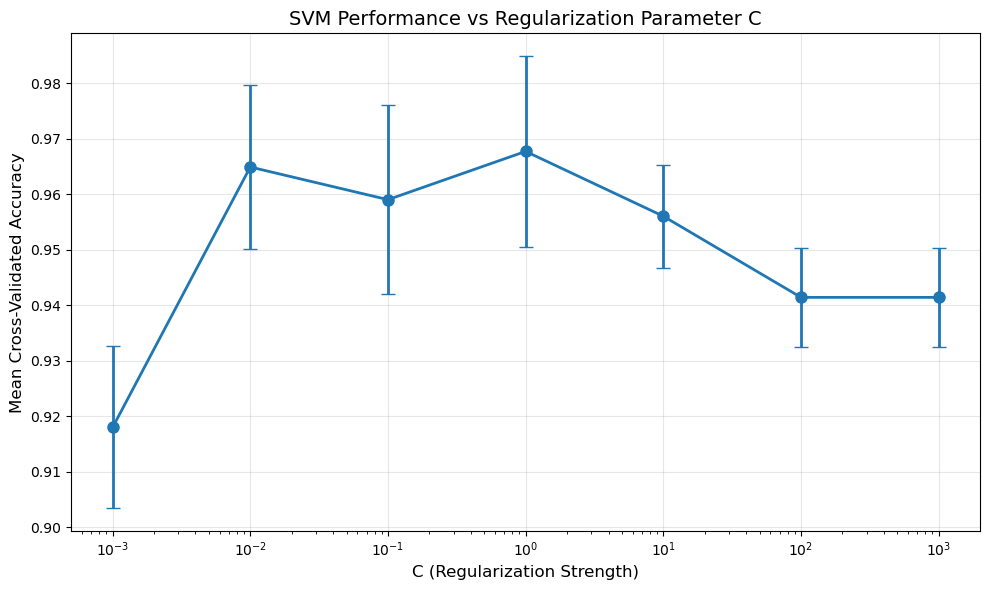

In [191]:
# 10 scale
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

mean_accuracies = []
std_accuracies = []

for C in C_values:
    pipeline = Pipeline([
        ('svm', SVC(kernel='linear', C=C, probability=True, random_state=1337))
    ])
    
    # Cross-validated accuracy, gir StratisfiedKFold til cross-val (cv)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='accuracy')
    mean_acc = np.mean(cv_scores)
    std_acc = np.std(cv_scores)
    
    mean_accuracies.append(mean_acc)
    std_accuracies.append(std_acc)

# Plot accuracy vs C
plt.figure(figsize=(10, 6))
plt.errorbar(C_values, mean_accuracies, yerr=std_accuracies, 
             marker='o', linestyle='-', linewidth=2, markersize=8, capsize=5)
plt.xscale('log')
plt.xlabel('C (Regularization Strength)', fontsize=12)
plt.ylabel('Mean Cross-Validated Accuracy', fontsize=12)
plt.title('SVM Performance vs Regularization Parameter C', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Notat

Målet er å minimere miss-klassifiseringer.\
Lav C = Kan gå med på noen feile klassifiseringer\
Høy C = Streng straff på feil klassifisering, blir en kronglete vei mellom datapunktene

Vi ser at 1 er den beste verdien for C med en mean nøyaktighet på 0.9795 og lavest standardavvik mellom alle de ulike verdiene. 

Kan teste videre med 0.1 steps mellom 0.1 og 10 for å finne den aller beste verdien.

# Q 3.4
Experiment with different γ values for the RBF kernel. Discuss the effect on bias-
variance trade-off for all experimented values. Select the best γ using the validation
set and report the performance on validation set. 


Best gamma: 0.01 with accuracy: 0.9678 ± 0.0109


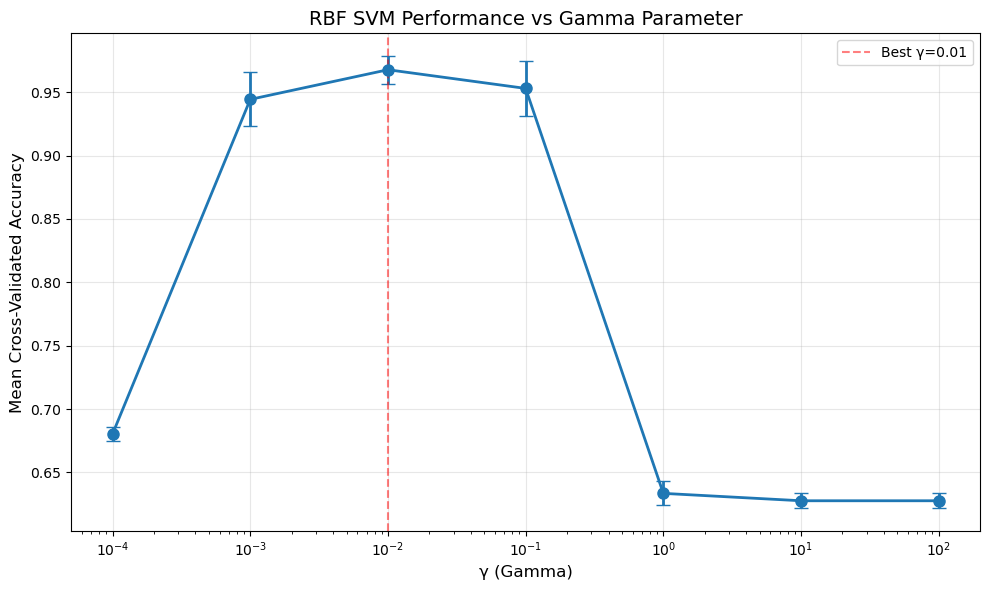

In [192]:
gamma_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

mean_accuracies_gamma = []
std_accuracies_gamma = []

for gamma in gamma_values:
    pipeline = Pipeline([
        ('svm', SVC(kernel='rbf', gamma=gamma, probability=True, random_state=42))
    ])
    
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='accuracy')
    mean_acc = np.mean(cv_scores)
    std_acc = np.std(cv_scores)
    
    mean_accuracies_gamma.append(mean_acc)
    std_accuracies_gamma.append(std_acc)

best_idx = np.argmax(mean_accuracies_gamma) # Høyest mean accuracy er beste idx
best_gamma = gamma_values[best_idx]
best_acc_gamma = mean_accuracies_gamma[best_idx]
best_std_gamma = std_accuracies_gamma[best_idx]

print(f"\nBest gamma: {best_gamma} with accuracy: {best_acc_gamma:.4f} ± {best_std_gamma:.4f}")

plt.figure(figsize=(10, 6))
plt.errorbar(gamma_values, mean_accuracies_gamma, yerr=std_accuracies_gamma, 
             marker='o', linestyle='-', linewidth=2, markersize=8, capsize=5)
plt.xscale('log')
plt.xlabel('γ (Gamma)', fontsize=12)
plt.ylabel('Mean Cross-Validated Accuracy', fontsize=12)
plt.title('RBF SVM Performance vs Gamma Parameter', fontsize=14)
plt.grid(True, alpha=0.3)
plt.axvline(x=best_gamma, color='r', linestyle='--', alpha=0.5, label=f'Best γ={best_gamma}')
plt.legend()
plt.tight_layout()
plt.show()

Vi ser at 0.01 gir høyest snitt-nøyaktighet med et standardavvik som er ganske bra, henger litt etter 0.001.

Vi ser en tydelig trend over hvordan ulike gamma verdier funker på RBF kernel med dette datasettet.

Lav gamma (10E-4, 10E-3) gir underfitting med høy bias
Høy gamma (10E-1 - 10E2) gir overfitting med høy varianse og 

# Q 4.1
Compare Decision Tree and SVM results from the training set (cross-validation
mean ± std) and validation set. Plot the performance comparison plots (e.g.,
scatter plots, ROC curves). Which model generalizes better?

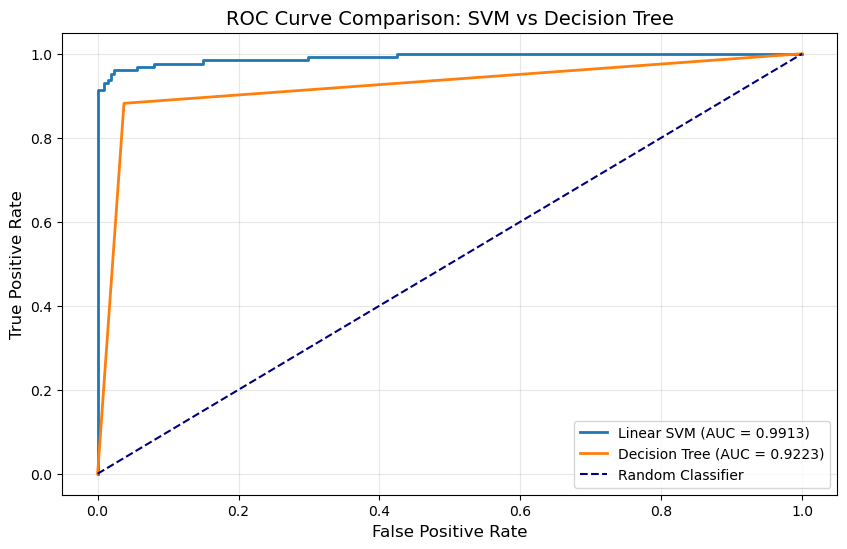

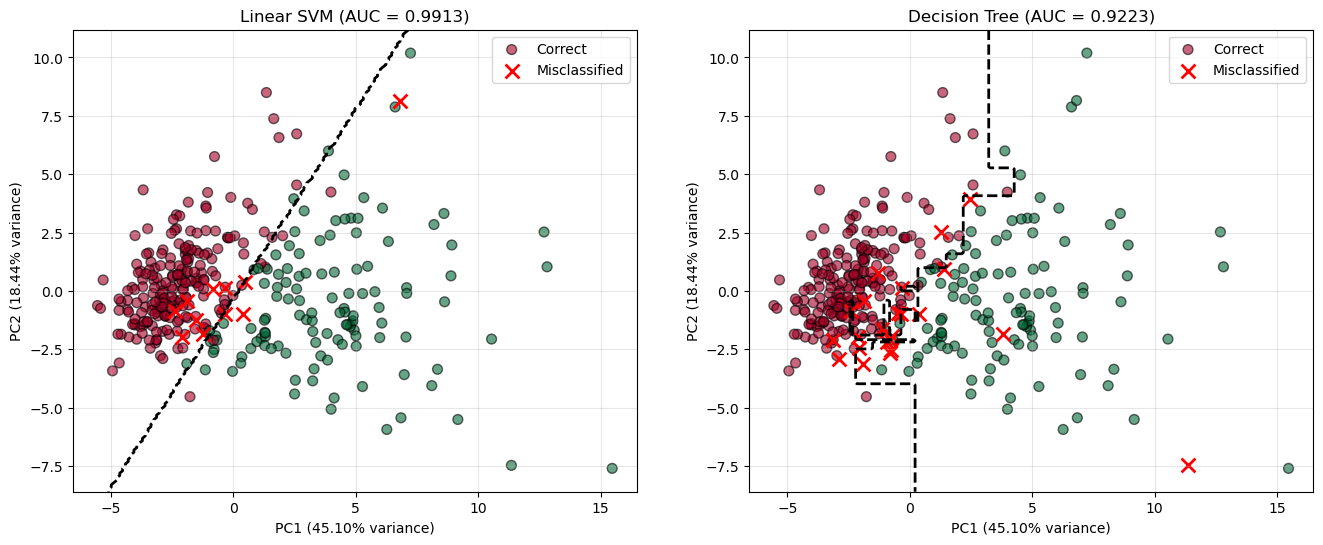

In [193]:
from sklearn.decomposition import PCA
import numpy as np

# SVM med Linear kernel = Occams razor, alltid velg enkleste (veldig lik performance fra AUC)
svm_pipeline = Pipeline([
    ("svm", SVC(kernel='linear',  probability=True, random_state=1337))
])

# Cross-validated predicted probabilities for ROC
y_pred_prob_svm = cross_val_predict(
    svm_pipeline, X_train, y_train, cv=kf, method='predict_proba'
)

# Default decision tree (Med scaling, brukes ikke i pred men brukes i scatter plot)
tree_pipeline = Pipeline([
    ("tree", DecisionTreeClassifier(random_state=1337))
])

# Cross-validated predicted probabilities for ROC
y_pred_prob_tree = cross_val_predict(
    tree_pipeline, X_train, y_train, cv=kf, method='predict_proba'
)

fpr_svm, tpr_svm, _ = roc_curve(y_train, y_pred_prob_svm[:, 1])
fpr_tree, tpr_tree, _ = roc_curve(y_train, y_pred_prob_tree[:, 1])
roc_auc_svm = auc(fpr_svm, tpr_svm)
roc_auc_tree = auc(fpr_tree, tpr_tree)

# Reciever Operational Characteristics Plot
plt.figure(figsize=(10, 6))
for name, y_pred_prob in [
    ('Linear SVM', y_pred_prob_svm),
    ('Decision Tree', y_pred_prob_tree)
]:
    fpr, tpr, _ = roc_curve(y_train, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Classifier')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve Comparison: SVM vs Decision Tree", fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Calculate agreement
svm_pred = (y_pred_prob_svm[:, 1] > 0.5).astype(int)
tree_pred = (y_pred_prob_tree[:, 1] > 0.5).astype(int)
agreement = (svm_pred == tree_pred)

# PCA transformation
pca = PCA(n_components=2)
scaler = StandardScaler()
X_train_pca = pca.fit_transform(scaler.fit_transform(X_train))

# Get predictions
y_pred_svm_labels = cross_val_predict(svm_pipeline, X_train, y_train, cv=kf)
y_pred_tree_labels = cross_val_predict(tree_pipeline, X_train, y_train, cv=kf)

# Train models on PCA data for decision boundaries
svm_pca = SVC(kernel='linear', random_state=1337).fit(X_train_pca, y_train)
tree_pca = DecisionTreeClassifier(random_state=1337).fit(X_train_pca, y_train)

# Mesh for decision boundary
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, model, y_pred, auc_score, name in [
    (axes[0], svm_pca, y_pred_svm_labels, roc_auc_svm, 'Linear SVM'),
    (axes[1], tree_pca, y_pred_tree_labels, roc_auc_tree, 'Decision Tree')
]:
    # Decision boundary
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contour(xx, yy, Z, colors='black', linewidths=2, linestyles='--', levels=[0.5])
    
    # Scatter points
    correct = y_train == y_pred
    scatter = ax.scatter(
        X_train_pca[correct, 0], X_train_pca[correct, 1],
        c=y_train[correct], cmap='RdYlGn', alpha=0.6, edgecolors='k', s=50, label='Correct'
    )
    ax.scatter(
        X_train_pca[~correct, 0], X_train_pca[~correct, 1],
        c='red', marker='x', s=100, linewidths=2, label='Misclassified'
    )
    
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    ax.set_title(f'{name} (AUC = {auc_score:.4f})')
    ax.legend()
    ax.grid(alpha=0.3)

plt.show()

## Generalisering
AUC for begge modeller er høy, men SVM slår Treet betydelig. 

Vi ser at begge modellene generaliserer bra gjennom scatter plot, hvor det lages klynger i begge ender av skalaen (som det skal, fordi det kun er 2 mulige klassifiseringer). Scatter plottet også sier at det er enighet i de som ligger langs grafen. 

## Accuracy
SVM har litt bedre accuracy (TP/TP+FP), med `0.0499` i favør for SVM. De scorer begge høyt uansett.

# Q 4.2
Discuss the trade-off between usability and accuracy for this dataset. Which model
would you recommend for a medical decision-support system, and why? (Hint -
Make use of Fβ score analysis) 

### Utgangspunkt
Jeg tar utgangspunk i at man skal vurdere modellene i utgangspunkt av Recall (sensitivitet) (TP/TP+FN), hvor det er veldig dumpt å misse positive. Det er dumt med FP, men det er ikke verre enn å gjøre ekstra tester.

### Diskusjon
#### SVM
Rask bruk etter ferdigtrent, mer stabil, men mindre fleksibel mot ikke-lineære sammenhenger

#### Trær
Lesbar "Hvis alder > 50 og størrelse > X så..", håndterer manglende variabler bedre, mindre stabil.


Klassifiseringer fra treet er veldig lette for mennesker å skjønne. \
Klassifiseringer fra SVM kan brukes av leger. "87% sjanse for kreft" kan undersøkes nærmere.

### F_beta-score
Beta < 1: Favør mot presisjon (Ikke det vi vil ha)
Beta = 1: Balansert
Beta > 1: Favør mot recall (Det vi vil ha)

F2 scoring er det vi vil ha, hvor recall er 4x viktigere enn presisjon

## Konklusjon
Basert på F2-score og viktigheten av høy recall, anbefaler jeg SVM med RBF-kernel for et medisinsk beslutningsstøttesystem. Selv om beslutningstrær er mer tolkbare, gir SVM bedre nøyaktighet og høyere recall, noe som er avgjørende for å redusere risikoen for uoppdaget kreft.

# Q 4.3
Use GridSearchCV with the training set to tune hyperparameters for both Decision
Trees and SVMs. Confirm your final choice with the validation set. Summarize the
best settings and provide relevant performance plots. 

# Decision Tree

Fitting 5 folds for each of 288 candidates, totalling 1440 fits

Decision Tree - Best Parameters:
  tree__class_weight: None
  tree__criterion: entropy
  tree__max_depth: 10
  tree__max_features: sqrt
  tree__min_samples_leaf: 1
  tree__min_samples_split: 2

Best F2 Score (CV): 0.9348
Validation Set Accuracy: 1.0000
Validation Set F2 Score: 1.0000


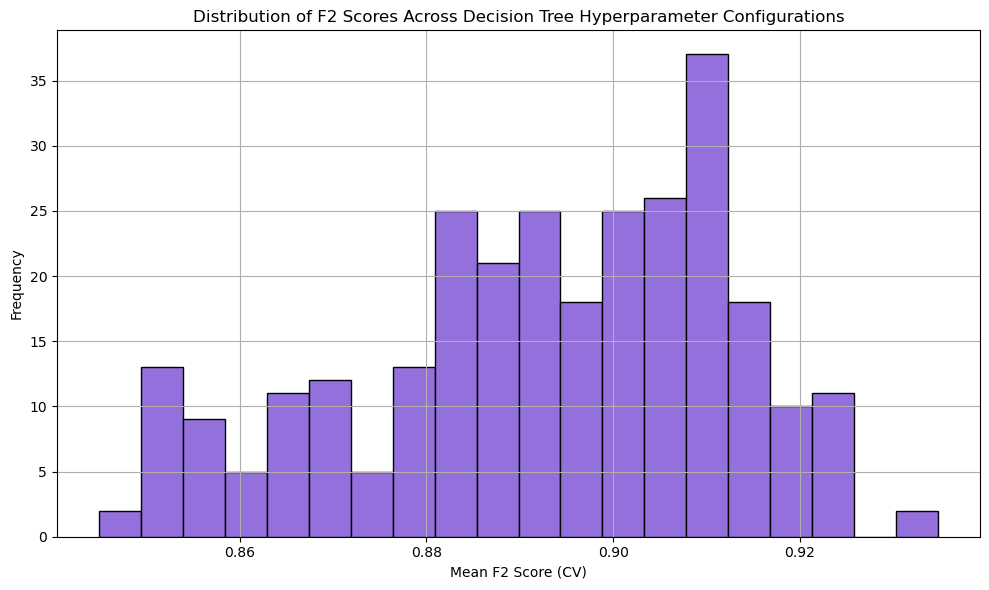

In [194]:
# Tre
f2_scorer = make_scorer(fbeta_score, beta=2)

tree_param_grid = {
    'tree__max_depth': [3, 5, 7, 10, 15, 20, None],
    'tree__min_samples_split': [2, 5, 10, 20],
    'tree__min_samples_leaf': [1, 2, 5, 10],
    'tree__criterion': ['gini', 'entropy'],
    'tree__class_weight': ['balanced', None]
}
tree_param_grid = {
    'tree__max_depth': [3, 5, 7, 10, 15, 20, None],
    'tree__min_samples_split': [2, 5, 10, 20],
    'tree__min_samples_leaf': [1, 2, 5, 10],
    'tree__criterion': ['gini', 'entropy'],
    'tree__class_weight': ['balanced', None],
    'tree__max_features': [None, 'sqrt', 'log2'],           # Number of features considered at each split
    'tree__max_leaf_nodes': [None, 10, 20, 50],             # Max number of leaf nodes
    'tree__min_impurity_decrease': [0.0, 0.001, 0.01],      # Minimum impurity decrease to split
    'tree__splitter': ['best', 'random'],                   # How to choose splits
    'tree__ccp_alpha': [0.0, 0.001, 0.01]                  # Cost-complexity pruning
}
tree_param_grid = {
    'tree__max_depth': [3, 5, 10, None],          # Focus on small to moderate depths
    'tree__min_samples_split': [2, 5, 10],       # Fewer options
    'tree__min_samples_leaf': [1, 2, 5],         # Common leaf sizes
    'tree__criterion': ['gini', 'entropy'],      
    'tree__class_weight': ['balanced', None],    
    'tree__max_features': [None, 'sqrt'],        # Only the most common choices
}


tree_pipeline = Pipeline([
    ('tree', DecisionTreeClassifier(random_state=1337))
])

tree_grid = GridSearchCV(
    tree_pipeline,
    tree_param_grid,
    cv=kf,
    scoring=f2_scorer,  # F2 (recall-fokusetr)
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

tree_grid.fit(X_train, y_train)

best_tree_model = tree_grid.best_estimator_

print("\nDecision Tree - Best Parameters:")
for param, value in tree_grid.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest F2 Score (CV): {tree_grid.best_score_:.4f}")

# Confirm on validation set
tree_val_acc = best_tree_model.score(X_val, y_val)
tree_val_f2 = fbeta_score(y_val, best_tree_model.predict(X_val), beta=2)
print(f"Validation Set Accuracy: {tree_val_acc:.4f}")
print(f"Validation Set F2 Score: {tree_val_f2:.4f}")

# Convert results to DataFrame
results_df = pd.DataFrame(tree_grid.cv_results_)

# Plot histogram of F2 scores
plt.figure(figsize=(10, 6))
plt.hist(results_df['mean_test_score'], bins=20, color='mediumpurple', edgecolor='black')
plt.xlabel('Mean F2 Score (CV)')
plt.ylabel('Frequency')
plt.title('Distribution of F2 Scores Across Decision Tree Hyperparameter Configurations')
plt.grid(True)
plt.tight_layout()
plt.savefig('svm_f2_score_distribution.png')

Veldig skjør mot hyperparameter tuning, bare noen gir veldig bra resultater på `0.94`, mens de fleste ligger på rundt `0.927`

# SVM

Fitting 5 folds for each of 36 candidates, totalling 180 fits

SVM - Best Parameters:
  svm__C: 10
  svm__class_weight: balanced
  svm__gamma: 0.01
  svm__kernel: rbf

Best F2 Score (CV): 0.9636
Validation Set Accuracy: 0.9853
Validation Set F2 Score: 0.9690


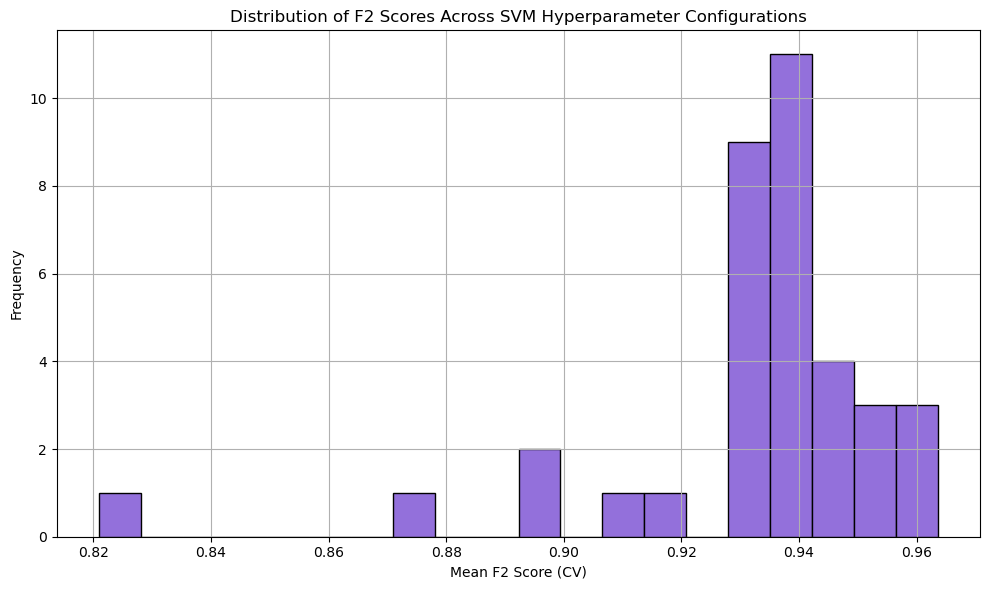

In [195]:
# SVM
svm_param_grid = {
    'svm__C': [0.01, 0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'svm__class_weight': ['balanced', None],
}

svm_pipeline = Pipeline([
    ('svm', SVC(probability=True, random_state=1337))
])

svm_param_grid = {
    'svm__C': [0.01, 0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'svm__gamma': ['scale', 'auto', 0.001, 0.01, 0.1],   # For rbf, poly, sigmoid
    'svm__class_weight': ['balanced', None],
    'svm__degree': [2, 3, 4],                             # Only used for poly kernel
    'svm__coef0': [0.0, 0.1, 0.5, 1.0],                  # Only for poly and sigmoid
    'svm__tol': [1e-3, 1e-4, 1e-5],                       # Stopping tolerance
    'svm__shrinking': [True, False],
    'svm__max_iter': [-1, 1000, 5000]                     # Max iterations, -1 = no limit
}
svm_param_grid = {
    'svm__C': [0.1, 1, 10],                     # Focus on typical ranges
    'svm__kernel': ['linear', 'rbf'],          # Only linear and RBF
    'svm__gamma': ['scale', 0.01, 0.1],        # Common gamma values for RBF
    'svm__class_weight': ['balanced', None],   
}

svm_grid = GridSearchCV(
    svm_pipeline,
    svm_param_grid,
    cv=kf,
    scoring=f2_scorer,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

svm_grid.fit(X_train, y_train)

best_svm_model = svm_grid.best_estimator_

print("\nSVM - Best Parameters:")
for param, value in svm_grid.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest F2 Score (CV): {svm_grid.best_score_:.4f}")

# Confirm on validation set
svm_val_acc = best_svm_model.score(X_val, y_val)
svm_val_f2 = fbeta_score(y_val, best_svm_model.predict(X_val), beta=2)
print(f"Validation Set Accuracy: {svm_val_acc:.4f}")
print(f"Validation Set F2 Score: {svm_val_f2:.4f}")

results_df = pd.DataFrame(svm_grid.cv_results_)

# Plot histogram of F2 scores
plt.figure(figsize=(10, 6))
plt.hist(results_df['mean_test_score'], bins=20, color='mediumpurple', edgecolor='black')
plt.xlabel('Mean F2 Score (CV)')
plt.ylabel('Frequency')
plt.title('Distribution of F2 Scores Across SVM Hyperparameter Configurations')
plt.grid(True)
plt.tight_layout()

Veldig lite skjør mot hyperparameter tuning, ser at de fleste gir et bra resultat på rundt `0.96`

# Q 4.4
Compare the final test set accuracy of the best Decision Tree and best SVM. Which
model performs better in practice? 

/var/folders/bq/r70fvlqs6y1_b_61g19z0y6c0000gn/T/ipykernel_53918/2396737093.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([svm_scores, tree_scores], labels=['Linear SVM', 'Decision Tree'],


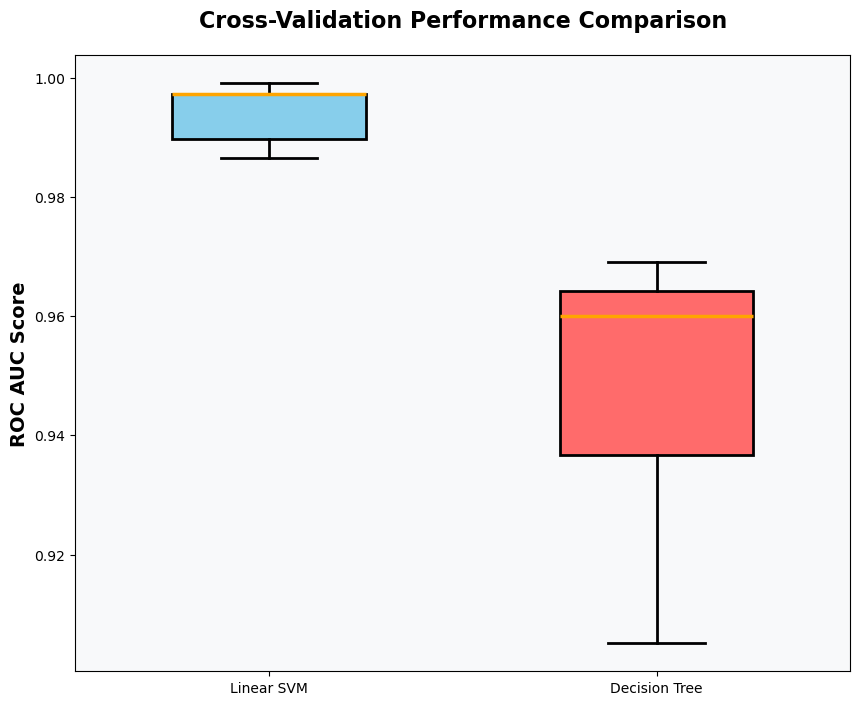

Decision Tree Test Accuracy: 0.9298
SVM Test Accuracy: 0.9649
The model that performs better on the test set is: SVM


In [196]:
from scipy import stats

best_tree_model.fit(X_train, y_train)
best_svm_model.fit(X_train, y_train)

dt_test_acc = accuracy_score(y_test, best_tree_model.predict(X_test))
svm_test_acc = accuracy_score(y_test, best_svm_model.predict(X_test))

tree_scores = cross_val_score(best_tree_model, X_train, y_train, cv=kf, scoring='roc_auc')
svm_scores = cross_val_score(best_svm_model, X_train, y_train, cv=kf, scoring='roc_auc')


t_stat, p_value = stats.ttest_rel(svm_scores, tree_scores)

fig, ax = plt.subplots(figsize=(10, 8))

bp = ax.boxplot([svm_scores, tree_scores], labels=['Linear SVM', 'Decision Tree'], 
                 patch_artist=True, widths=0.5,
                 boxprops=dict(linewidth=2),
                 whiskerprops=dict(linewidth=2),
                 capprops=dict(linewidth=2),
                 medianprops=dict(color='orange', linewidth=2.5))

bp['boxes'][0].set_facecolor('#87CEEB')  # Sky blue
bp['boxes'][1].set_facecolor('#FF6B6B')  # Soft red

# Styling
ax.set_ylabel('ROC AUC Score', fontsize=14, fontweight='bold')
ax.set_title('Cross-Validation Performance Comparison', fontsize=16, fontweight='bold', pad=20)
ax.set_facecolor('#F8F9FA')

plt.show()

print(f"Decision Tree Test Accuracy: {dt_test_acc:.4f}")
print(f"SVM Test Accuracy: {svm_test_acc:.4f}")

# Determine better model
better_model = 'SVM' if svm_test_acc > dt_test_acc else 'Decision Tree'
print(f"The model that performs better on the test set is: {better_model}")


# Q 4.5
The Breast Cancer Wisconsin dataset has 30 continuous features, many of which
are correlated and not linearly separable. Explain why a linear SVM might fail
to capture complex patterns in this dataset. How does using an RBF kernel help
in this case? Discuss your answer in terms of the dataset’s feature space and the
geometry of the decision boundary. 

Om data er korrelert, så kan ikke en lineær linje separere dataene uten betydelig reduksjon i accuracy. En RBF kjerne klarer å separere datane bedre ved å 